# 为什么将不同家系后代混合再选择是不可行的？

## 说明
以下一些简单模拟包括了一些代码和说明文字，可暂时忽略代码。

In [2]:
using DataFrames

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278


## 模拟

我们简单模拟
  - 100 个全同胞家系
  - 每个家系的大小是 1000 个全同胞。

第 $i$ 家系中第 $j$ 个体的表现型记录可以用以下的式子表示：

$$y_{ij} = \mu + \frac{s_i + d_i}{2} + m_i + e_{ij}$$

说成白话就是这一百个家系中的第 $i$ 个家系中的第 $j (j=1\cdots 1000)$ 个体的表现型等于它父母育种值的平均数，加上父母在传代时的孟德尔抽样误差，再加上一个随机环境效应。这里我们假设群体的平均数 $\mu=0$。

其中：
  - $s_i$ 是第 $i$ 家系的父本
  - $d_i$ 是第 $i$ 家系的母本
  - 假定 $s_i,\,d_i\sim N(0, 1)$
  - $m_i$ 是以上两个亲本后代产生后代的孟德尔抽样误差，则 $m_i\sim N(0, \frac{1}{2})$
  - $e_{i,j}$ 是随机环境效应，设 $e_{ij} \sim N(0, 1)$

### 孟德尔抽样误差

In [11]:
repeat([1 -1], 10)'

2×10 LinearAlgebra.Adjoint{Int64,Array{Int64,2}}:
  1   1   1   1   1   1   1   1   1   1
 -1  -1  -1  -1  -1  -1  -1  -1  -1  -1

如上，假定上面的两行数的每一行代表一对同源染色体中的一条上的 QTL 基因型，那么由于独立分配，这样的两个个体交配产生的后代的基因型可以从：

In [12]:
repeat([-1 -1], 10)'

2×10 LinearAlgebra.Adjoint{Int64,Array{Int64,2}}:
 -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1  -1

到

In [13]:
repeat([1 1], 10)'

2×10 LinearAlgebra.Adjoint{Int64,Array{Int64,2}}:
 1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1

前者的育种值是 -20，后者的育种值是 20。如果产生的个体很多，那么这些个体的平均育种值大致是期望值 0。后代育种值与期望值的偏差就是**孟德尔抽样误差**。

### 基础群到第一代

In [19]:
nfam = 100   # 假定 100 个全同胞家系
nsib = 1000  # 假定每个全同胞家系 1000 个全同胞
nid  = nfam * nsib # 总个体数

# 个体家系号和个体号
family = repeat(1:nfam, inner=nsib) # [1, 1, ..., 2, 2, ..., ..., 100, 100, ...]
ID = repeat(1:nsib, nfam)           # [1, 2, 3, ..., 1, 2, 3, ..., ..., 1, 2, 3, ...]

# 基础群的真实育种值
BV = randn(2nfam)                   # 200 个亲代的真实育种值。假定家系 1 的父母是: 1, 2, 2: 3, 4; ... 家系 100: 199, 200

# 这样后代的真实育种值就是
bv = begin  # 后代的育种值
    t = zeros(Float64, nid)
    for i in 1:nfam                   # 100 个家系中的第 i 个
        ave = (BV[2i-1] + BV[2i]) / 2 # 后代期望是父母育种值的平均数
        ms  = randn(1000) .* √.5      # 1000 个全同胞的孟德尔抽样误差
        to  = 1000i
        from= to - 999
        t[from:to] = ms .+ ave
    end
    t
end
    
err = randn(nid)       # 十万个体的随机环境效应，也服从 N(0, 1)
phenotype = bv + err  # 这样，这十万个体的表现型值服从 N(0, 2)
dat = DataFrame(family = family, ID = ID, TBV = bv, phenotype = phenotype)
first(dat, 10)

,family,ID,TBV,phenotype
,Int64,Int64,Float64,Float64
1,1,1,-0.274925,0.506994
2,1,2,1.24005,1.38509
3,1,3,-0.0706405,-0.289919
4,1,4,1.09557,2.30861
5,1,5,0.249275,0.223384
6,1,6,0.00747928,-1.02381
7,1,7,-0.532343,-0.838219
8,1,8,-1.67008,-2.31121
9,1,9,-0.29758,-0.024025


以上随机产生了 $10^5$ 个个体，分属 100 个家系。我把第一个家系的前 10 个个体打印了出来。

现在我们把这十万个体完全混合在一块，然后从中选取最佳的一万个：

In [20]:
best10k = sort(dat, [:phenotype], rev=true)[1:10000, :]
first(best10k, 10)  # 打印表现最好的 10 个个体

,family,ID,TBV,phenotype
,Int64,Int64,Float64,Float64
1,5,166,3.51767,6.34727
2,26,90,3.62614,6.00658
3,88,964,3.36119,5.62539
4,52,108,2.58983,5.51615
5,56,60,2.69192,5.41402
6,55,399,2.61782,5.40319
7,77,180,2.71994,5.3844
8,5,98,2.77362,5.35127
9,55,199,2.35101,5.34546


这十万个体分属不同的家系。而每个家系各被选中了多少个体可以从下面的柱状图一目了然：

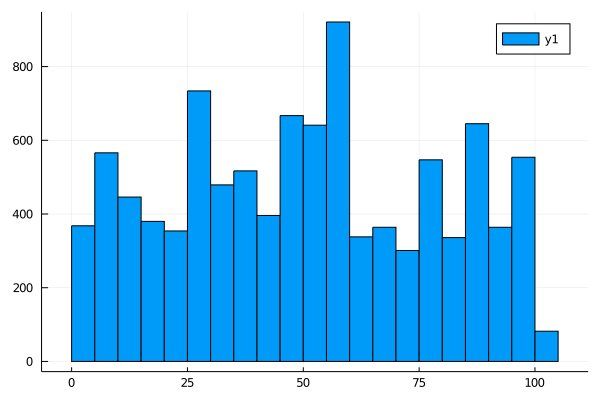

In [22]:
using Plots
histogram(best10k[:, :family])

In [23]:
using FreqTables
freqtable(best10k[:, :family])

┌ Info: Precompiling FreqTables [da1fdf0e-e0ff-5433-a45f-9bb5ff651cb1]
└ @ Base loading.jl:1278


100-element Named Array{Int64,1}
Dim1  │ 
──────┼────
1     │  42
2     │  44
3     │ 141
4     │ 141
5     │ 323
6     │  34
7     │  25
8     │  91
9     │  93
10    │   6
11    │ 142
12    │  83
⋮         ⋮
89    │ 146
90    │  51
91    │  17
92    │  98
93    │ 120
94    │  78
95    │ 139
96    │  70
97    │ 223
98    │   5
99    │ 117
100   │  82

从这里已经可以看出混合群体之后选择最好的个体各个家系被选中的个数很糟糕。比如有的只有个位数。有的则多了一倍以上。当然，这也很容易理解，即好的家系的个体更容易被选中。假如我们的育种值估计 100% 的准确，我们再从后代选取育种值最佳的 200 个后代。

In [24]:
best2d = sort(dat, [:TBV], rev=true)[1:200, :]
unique(best2d[:, :family])

23-element Array{Int64,1}:
 46
 26
 88
  5
 34
 55
 77
 52
 56
 93
 97
 54
 57
 25
 71
 40
 89
 39
 18
 94
 38
 14
  3

可见原先 100 个家系仅经一代选择只剩下了 23 个。这样降低的速度在育种中是很可怕的。只需两三代，所有的核心群可能就只来自于一两个家系。育种将会因为近交而无法进行。

## 解决办法

一种办法是家系内选择。因为孟德尔抽样误差，全同胞们的育种值是不一样的。与传统 BLUP 方法不同，基因组选择可以估计这种差别。这样每一代在在同一家系中选择最好的两只，然后在下一代中组合新的家系，重新在新的家系中进行家系内选择。新家系的组合可以随机，并避免近交。也可以根据基因型结果优化组合。时间关系，我今天就模拟这么多。